# Fixed Point Linear Regression on an FPGA

This jupyter notebook defines a hardware driver so that we can interact with our Linear Regression IP directly within our python environment. It also times the hardware based implementation versus a numpy based pure software approach. 

For this project we use fixedpoint for conversion of floating point numbers to fixed point numbers and vice versa. We also use the Overlay and DefaultIP classes from the pynq package, which allows us to load our FPGA bitstreams onto the fabric and then interact with it in python. The DefaultIP class can then be used as a super class to define a driver to allow users to interact with the IP in one line. Numpy and matplotlib are used for the creation of random numbers for input and plotting of output respectively.

In [1]:
from fixedpoint import FixedPoint
from pynq import Overlay
from pynq import DefaultIP
import matplotlib.pyplot as plt
import numpy as np

## Driver Definition
In this cell we define the driver that handles converting and sending/recieving values between the jupyter environment and the hardware accelerator. 

It inherits most base functionality from the DefaultIP class. This class alos allows us to define an IP source for the driver to bind to, so any overlay that gets loaded will automatically bind this funtionality to that IP within the overlay. In our case we specify that it should tie to IP spawned from our hls file called calcXTX.

This is useful as it allows us to reuse this code with multiple versions of our IP as we iterate and modify our design, as it will automatically bind to our design.

In [2]:
class linRegPredDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
        
    bindto = ['xilinx.com:hls:calcXTX:1.0']
    
    #given array[8] of floats, x and y, will perform linear regression and return best fit y's for same input x's
    def linReg(self, xFloat, yFloat):
        
        #convert inputs into fixedpoint numbers
        xFixed = [FixedPoint(x, True, 16, 16) for x in xFloat]
        yFixed = [FixedPoint(y, True, 16, 16) for y in yFloat]
        
        #get integers corresponding with bitvalues of floating point numbers
        intBits = []
        for x in xFixed:
            intBits.append(int(x.bits))

        for y in yFixed:
            intBits.append(int(y.bits))

        #write inputs to corresponding ports using address offsets
        for i in range(0, 16, 1):
            self.write(i*8+16, intBits[i])
        
        #send start signal
        self.write(0x00, 1)
        
        #create a fixedpoint class instance for reading and converting return value back into float
        qformat = {'signed': True, 'm': 16, 'n': 16}
        retFixed = FixedPoint(0, **qformat)
        yOut = []
        for i in range(0, 8, 1):
            #read return from ports, happens as int rep of fixed point
            out = self.read((i*16)+0x90)
            #convert int to hex string, use that to set fixedpoint to correct value
            retFixed.from_string(hex(out))
            #cast to float and append to return list
            yOut.append(float(retFixed))
            
        return yOut

## Overlay Loading
We currently have two overlays, v3 and v4. The main difference is that v4 uses division approximation for the calculation of the inverse of our determinant, whereas v3 uses a proper divider. v3 is a little slower, and also uses more power and hardware resources. However it is slightly more accurate, and also accurate over a larger range of inputs. 

In [ ]:
overlay = Overlay('/home/xilinx/pynq/overlays/linRegOverlays/directImp_v3.bit')
#overlay?

In [3]:
overlay = Overlay('/home/xilinx/pynq/overlays/linRegOverlays/directImp_v4.bit')
#overlay?

## Input Generation
We have three cells that provide possible inputs for our driver. The first two are inputs used by the reference paper as testing data, and so we use those as direct comparison for our results. The third one uses numpy to generate sorted arrays of 8 random floating point values with a given absolute value, and can be switched from positive or negitive regression depending on the ordering of the Y values. 

In [4]:
X_float = [-1.1, 0.1, 1.2, 2.3, 3.1, 4.1, 4.8, 5.7]
y_float = [-1.7, 2.4, 5.0, 7.3, 10.9, 12.5, 16.2, 19.7]

In [ ]:
X_float = [-4.0, -3.3, -2.2, -0.7, 0.1, 1.1, 2.3, 3.4]
y_float = [8.5, 7.6, 5.2, 3.9, 2.1, 0.8, 0.3, -2.1]

In [ ]:
absMax = 35
X_float = np.sort(np.random.uniform(low=-absMax, high=absMax, size=(8,)))
y_float = np.sort(np.random.uniform(low=-absMax, high=absMax, size=(8,)))
#y_float = -np.sort(-np.random.uniform(low=-absMax, high=absMax, size=(8,)))
print(X_float, y_float)

## Runtime
Using jupyter notebook magic time commands we can time both the driver invocation and our direct algorithm implementation in a .py file. The driver is typically around 10X faster than the direct numpy implementation. We also use matplotlib to plot the output results from our driver against the input value, so that we can quickly visualize how well it does as a line of best fit.

In [5]:
%%time
results = overlay.linReg.linReg(X_float, y_float)
print(results)

[-1.9049530029296875, 1.70611572265625, 5.0161895751953125, 8.326309204101562, 10.733673095703125, 13.74285888671875, 15.849273681640625, 18.557525634765625]
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.2 ms


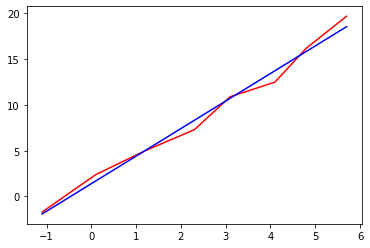

In [6]:
plt.plot(X_float, y_float, color = "#FF0000") #Red is generated numbers
plt.plot(X_float, results, color = "#0000FF") #Blue is hardware output line of best fit

In [7]:
%%time
!python /home/xilinx/python/linear_regression_1.py

Computed parameters: [1.41397352 3.01921841]
Training data  Prediction     Euclidean distance
(x, y)         Python                        
(-1.1, -1.7)   -1.90717       0.20717        
(0.1, 2.4)     1.71590        0.68410        
(1.2, 5.0)     5.03704        0.03704        
(2.3, 7.3)     8.35818        1.05818        
(3.1, 10.9)    10.77355       0.12645        
(4.1, 12.5)    13.79277       1.29277        
(4.8, 16.2)    15.90622       0.29378        
(5.7, 19.7)    18.62352       1.07648        
CPU times: user 155 ms, sys: 51.2 ms, total: 207 ms
Wall time: 1.74 s


## Limitations of Q16.16 Fixedpoint Numbers
Beyond having limited accuracy from being a fixed point number, using signed fixed point numbers also limits our model in that it provides a relatively small maximum number we can use for our internal values during calculation of our matrix components. For example, during calculation of our determinant, we need to calculate $nb-a^2$, wher $n$ is number of inputs ($8$) and $b = \sum_{i=0}^{n-1}x_i^2$. The maximum number we can represent in Q16.16 is roughly $32768$. Doing a bit of napkin math to find a rough maximum average absolute value of inputs $x$ we get:

$$
nb\leq 32768 \\
n(nx^2)\leq 32768 \\
8(8x^2)\leq 32768 \\
64x^2\leq 32768\\
x^2\leq 512\\
x\leq 22.627
$$

This is doing a bit of handwaving with turning $b = \sum_{i=0}^{n-1}x_i^2$ into $nx^2$ by claiming that we are looking for the average absolute value, but it illustrates the point that it doesn't take terribly large input numbers for these internal numbers to overflow. This determinant value is crucial for the entire operation and propagates to every value used and returned by the accelerator. As such if these values overflow, that error propagates to the entire result. This is all the more noticable for the aproxximated dvision implementation, which uses the determinant for more arithmetic operations in total.

There are some possible methods to address these issues. On the hardware side we could do things such as giving the hardware more bits to work with during the calculation of these internal steps, at the cost of larger design footprints and power usage. Similarly we could instead attempt a fully floating point version, but again this would increase the hardware and power utilization, and likely runtime as well. We could also take a more software based approach, scaling the input values down to be within an acceptable range, and then scaling final outputs back up. This method would increase data processing overheads on both ends, slowing down the accelerator total time, and also decrease accuracy further as the scaling operations would each incur precision loss.

Regardless, we believe this is why the original authors selected the input data they did, as the small numbers work well within this design.